In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# TẢI SPARK TRÊN GOOGLE COLAB ĐỂ CHẠY
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

!ls

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate() 
spark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://security.ubuntu.com/ubuntu focal-security InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Reading package lists... Done
drive	     spark-3.3.1-bin-hadoop3	  spark-3.3.1-bin-hadoop3

In [6]:
path="/content/drive/MyDrive/SE400.N12/segmentation-data.csv"

In [7]:
import sys
from pyspark import SparkContext, SparkConf
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from pyspark.sql.functions import col

In [8]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [9]:
# đọc dữ liệu vào dataframe
df = spark.read.option("header",True) \
     .csv(path)

In [10]:
#Xem trước tập dữ liệu
df.show()

+---------+---+--------------+---+---------+------+----------+---------------+
|       ID|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|
+---------+---+--------------+---+---------+------+----------+---------------+
|100000001|  0|             0| 67|        2|124670|         1|              2|
|100000002|  1|             1| 22|        1|150773|         1|              2|
|100000003|  0|             0| 49|        1| 89210|         0|              0|
|100000004|  0|             0| 45|        1|171565|         1|              1|
|100000005|  0|             0| 53|        1|149031|         1|              1|
|100000006|  0|             0| 35|        1|144848|         0|              0|
|100000007|  0|             0| 53|        1|156495|         1|              1|
|100000008|  0|             0| 35|        1|193621|         2|              1|
|100000009|  0|             1| 61|        2|151591|         0|              0|
|100000010|  0|             1| 28|        1|174646| 

In [11]:
# Xem thống kê tập dữ liệu
df.describe().show()

+-------+-----------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|               ID|                Sex|    Marital status|               Age|         Education|           Income|        Occupation|   Settlement size|
+-------+-----------------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|             2000|               2000|              2000|              2000|              2000|             2000|              2000|              2000|
|   mean|    1.000010005E8|              0.457|            0.4965|            35.909|             1.038|       120954.419|            0.8105|             0.739|
| stddev|577.4945887192364|0.49827215211045495|0.5001127936807873|11.719402339522171|0.5997798495564574|38108.82467857851|0.6385872272629721|0.8125325252273146|
|    min|        100000001|       

In [12]:

#Bỏ các cột thừa ID
columns_to_drop = ['ID']
df= df.drop(*columns_to_drop)
df.show()

+---+--------------+---+---------+------+----------+---------------+
|Sex|Marital status|Age|Education|Income|Occupation|Settlement size|
+---+--------------+---+---------+------+----------+---------------+
|  0|             0| 67|        2|124670|         1|              2|
|  1|             1| 22|        1|150773|         1|              2|
|  0|             0| 49|        1| 89210|         0|              0|
|  0|             0| 45|        1|171565|         1|              1|
|  0|             0| 53|        1|149031|         1|              1|
|  0|             0| 35|        1|144848|         0|              0|
|  0|             0| 53|        1|156495|         1|              1|
|  0|             0| 35|        1|193621|         2|              1|
|  0|             1| 61|        2|151591|         0|              0|
|  0|             1| 28|        1|174646|         2|              0|
|  1|             1| 25|        1|108469|         1|              0|
|  1|             1| 24|        1|

In [13]:
df = df.filter((df.Education!=0))

In [14]:
# xem tóm tắt của tập dữ liệu
# Chọn những cột cần thiết cho việc phân cụm
# Chuyển dữ liệu thành kiểu int để tính toán
df = df.withColumn("Sex", col("Sex").cast("int")) \
    .withColumn("Marital status", col("Marital status").cast("int")) \
    .withColumn("Age", col("Age").cast("int")) \
    .withColumn("Education", col("Education").cast("int")) \
    .withColumn("Income", col("Income").cast("int")) \
    .withColumn("Occupation", col("Occupation").cast("int")) \
    .withColumn("Settlement size", col("Settlement size").cast("int")) 

df.describe().show()

+-------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|summary|                Sex|    Marital status|               Age|          Education|            Income|        Occupation|   Settlement size|
+-------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|  count|               1713|              1713|              1713|               1713|              1713|              1713|              1713|
|   mean| 0.5148861646234676|0.5796847635726795|37.333333333333336| 1.2119089316987741|121940.60770577933|0.8166958552247519|0.7256275539988325|
| stddev|0.49992429497091123|0.4937536405711809|12.019762413355776|0.45733703100232287| 37694.64381283668|0.6441879344895582|0.8041383000426446|
|    min|                  0|                 0|                18|                  1|             35832|                 0|     

In [15]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1713 entries, 0 to 1712
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              1713 non-null   int32
 1   Marital status   1713 non-null   int32
 2   Age              1713 non-null   int32
 3   Education        1713 non-null   int32
 4   Income           1713 non-null   int32
 5   Occupation       1713 non-null   int32
 6   Settlement size  1713 non-null   int32
dtypes: int32(7)
memory usage: 47.0 KB


In [16]:
#Lọc những cột có Education =0 (những người ko có thông tin học vấn)
newdf=df.filter( (df.Education  != "0") ) \
        .toPandas().to_csv(r'mydatanew.csv', index = False, header = False)
        

In [17]:
#Lưu lại dữ liệu
newdata = spark.read.option("header",False) \
     .csv("/content/mydatanew.csv")

In [18]:
newdata.show()

+---+---+---+---+------+---+---+
|_c0|_c1|_c2|_c3|   _c4|_c5|_c6|
+---+---+---+---+------+---+---+
|  0|  0| 67|  2|124670|  1|  2|
|  1|  1| 22|  1|150773|  1|  2|
|  0|  0| 49|  1| 89210|  0|  0|
|  0|  0| 45|  1|171565|  1|  1|
|  0|  0| 53|  1|149031|  1|  1|
|  0|  0| 35|  1|144848|  0|  0|
|  0|  0| 53|  1|156495|  1|  1|
|  0|  0| 35|  1|193621|  2|  1|
|  0|  1| 61|  2|151591|  0|  0|
|  0|  1| 28|  1|174646|  2|  0|
|  1|  1| 25|  1|108469|  1|  0|
|  1|  1| 24|  1|127596|  1|  0|
|  1|  1| 22|  1|108687|  1|  2|
|  0|  0| 60|  2| 89374|  0|  0|
|  1|  1| 28|  1|102899|  1|  1|
|  1|  1| 32|  1| 88428|  0|  0|
|  0|  0| 53|  1|125550|  1|  0|
|  1|  1| 44|  2|261952|  2|  2|
|  0|  0| 48|  1|118777|  1|  1|
|  0|  0| 44|  1|147511|  1|  1|
+---+---+---+---+------+---+---+
only showing top 20 rows



In [19]:
# đọc dữ liệu vào RDD
fileRDD = sc.textFile("/content/mydatanew.csv",minPartitions=20)

In [20]:
# gắn số dòng cho từng dòng trong data, chuyển dữ liệu sang int *, thêm vào array
# key là số dòng, bắt đầu từ 0, giá trị là giá trị chuyển sang int * trong array
fileRDD=fileRDD.zipWithIndex().map(lambda x:(x[1],np.array([int(y) for y in x[0].split(',')])))

In [21]:
fileRDD.collect()

[(0, array([     0,      0,     67,      2, 124670,      1,      2])),
 (1, array([     1,      1,     22,      1, 150773,      1,      2])),
 (2, array([    0,     0,    49,     1, 89210,     0,     0])),
 (3, array([     0,      0,     45,      1, 171565,      1,      1])),
 (4, array([     0,      0,     53,      1, 149031,      1,      1])),
 (5, array([     0,      0,     35,      1, 144848,      0,      0])),
 (6, array([     0,      0,     53,      1, 156495,      1,      1])),
 (7, array([     0,      0,     35,      1, 193621,      2,      1])),
 (8, array([     0,      1,     61,      2, 151591,      0,      0])),
 (9, array([     0,      1,     28,      1, 174646,      2,      0])),
 (10, array([     1,      1,     25,      1, 108469,      1,      0])),
 (11, array([     1,      1,     24,      1, 127596,      1,      0])),
 (12, array([     1,      1,     22,      1, 108687,      1,      2])),
 (13, array([    0,     0,    60,     2, 89374,     0,     0])),
 (14, array([   

In [22]:
# Hàm: gắn cluster gần nhất cho từng dataPoint
# Đây là bước tìm tâm cụm cho việc khởi tạo
# x là mỗi dòng của RDD
def Cluster_Assign(x):
  # Temp là id của cụm
  temp=0
  # dis: khoảng cách từ datapoint tới cluster gần nhất
  distance=np.inf
  # lặp qua từng tâm cụm và gắn tâm cụm gần nhất cho dataPoint
  for i in clus_bd.value:
    # Tính khoảng cách
    d = np.square(np.sqrt(sum(np.square(np.subtract(x[1], i[1])))))
    # So sánh lấy khoảng cách ngắn hơn
    if d < distance:
      # Gắn lại các giá trị tâm cụm
      distance = d
      temp=i[0]
  return (temp,(distance,x[0],x[1]))

In [23]:
# hàm khởi tạo k tâm cụm bằng phương pháp k-mean++
def Gen_Init_Centroids(k):
  # Lấy tâm cụm đầu tiên
  # Lấy ngẫu nhiên một dòng dữ liệu để tạo thành tâm đầu tiên
  first_centroid=random.sample(range(fileRDD.count()),1)
  # Lấy giá trị tọa độ
  first_centroid_cord=fileRDD.filter(lambda x:x[0] in first_centroid)
  # Khai báo và thông báo biến ra ngoài
  global clus_bd
  clus_bd=sc.broadcast(first_centroid_cord.collect())
  for i in range(k-1):
    l = []
    bla=fileRDD.map(lambda x: Cluster_Assign(x))
    next_full = bla.max(key=lambda x: x[1][0]) # tìm điểm có khoảng cách xa nhất 
    next = (next_full[1][1], next_full[1][2]) # Lấy số lượng quan sát, vị trí tọa độ
  # Ghi các giá trị tâm cụm, giải phóng tài nguyên và thông báo ra toàn cụm máy 
    clus_bd.value.append(next)
    l = clus_bd.value
    clus_bd.unpersist()
    clus_bd = sc.broadcast(l)
    first_centroid.append(next[0])

In [24]:
# hàm khởi tạo k tâm cụm bằng phương pháp Naive (Forgy) (k-mean thường)
def Gen_Init_Centroids_Naive(k):
  # Lấy tâm cụm k ngẫu nhiên từ dữ liệu
  centroid=random.sample(range(fileRDD.count()),k)
  # Lấy tọa độ tâm cụm
  centroid_cord=fileRDD.filter(lambda x:x[0] in centroid)
  global clus_bd_naive
  clus_bd_naive=sc.broadcast(centroid_cord.collect())


In [25]:
# Tính khoảng cách Euclid và gắn dataPoint vào cluster (K-mean thuong)
def Euclid_Cluster_Assign_Naive(x,n):
  temp=0
  dist=np.inf
  # Duyệt qua tất cả n tâm
  for i in range(n):
    # Tính khoảng cách Euclid d
    # Công thức khoảng cách Euclidean , d(p, q) = sqrt((q_1 - p_1)^2 + (q_2 - p_2)^2)
    d = np.sqrt(sum(np.square(np.subtract(x[1], centroid_centres_bd_naive.value[i][1]))))
    # So sánh lấy khoảng cách ngắn nhất
    if d < dist:
      # Gắn Datapoint vào Cluster
      dist = d
      temp=centroid_centres_bd_naive.value[i][0]
      # Tính chi phí cost
      costf=dist**2
  return (temp,(x[0],x[1],costf))

In [26]:
# Tính khoảng cách Euclid và gắn dataPoint vào cluster (K-mean++)
def Euclid_Cluster_Assign(x,n):
  temp=0
  dist=np.inf
  # Duyệt qua tất cả n tâm
  for i in range(n):
    # Tính khoảng cách Euclid d
    # Công thức khoảng cách Euclidean , d(p, q) = sqrt((q_1 - p_1)^2 + (q_2 - p_2)^2)
    d = np.sqrt(sum(np.square(np.subtract(x[1], centroid_centres_bd.value[i][1]))))
    # So sánh lấy khoảng cách ngắn nhất
    if d < dist:
      # Gắn Datapoint vào Cluster
      dist = d
      temp=centroid_centres_bd.value[i][0]
      # Tính chi phí cost
      costf=dist**2
  return (temp,(x[0],x[1],costf))

In [27]:
# Tính khoảng cách Mahattan và gắn dataPoing vào cluster
def Mahattan_Cluster_Assign(x,n):
  temp=0
  dist=np.inf
  # Duyệt qua tất cả n tâm
  for i in range(n):
    # Tính khoảng cách Mahattan d
    # Công thức khoảng cách Manhattan , d(p, q) = |q_1 - p_1| + |q_2 - p_2|
    d = np.sum(np.absolute(np.subtract(x[1], centroid_centres_bd.value[i][1])))
    # So sánh lấy khoảng cách ngắn nhất
    if d < dist:
      # Gắn Datapoint vào Cluster
      dist = d
      temp=centroid_centres_bd.value[i][0]
      # Tính chi phí cost
      cost=dist**2
  return (temp,(x[0],x[1],cost))

In [28]:
# Tính khoảng cách Chebyshev và gắn dataPoing vào cluster
def Chebyshev_Cluster_Assign(x,n):
  temp=0
  dist=np.inf
  # Duyệt qua tất cả n tâm
  for i in range(n):
    # Tính khoảng cách Chebyshev d
    # Công thức Chebyshev, d(p, q) = max(|q_1 - p_1|, |q_2 - p_2|)
    d = np(max(np.absolute(np.subtract(x[1], centroid_centres_bd.value[i][1]))))
    # So sánh lấy khoảng cách ngắn nhất
    if d < dist:
      # Gắn Datapoint vào Cluster
      dist = d
      temp=centroid_centres_bd.value[i][0]
      # Tính chi phí cost
      cost=dist**2
  return (temp,(x[0],x[1],cost))

In [29]:
def kmeans(method, n_clus, n_iter):
  # khởi tạo các tâm cụm thông minh
  Gen_Init_Centroids(n_clus)
  cf=[]
  # chuyển method thành chữ viết thường (không hoa)
  method = method.lower()
  # khởi tạo và gắn các giá trị global sẽ được broadcast
  global centroid_centres_bd
  global label
  centroid_centres_bd=sc.broadcast(clus_bd.value)
  # Chạy các vòng lặp lại thuật toán
  for i in range(n_iter):
    if method == 'e':
      # tính khoảng cách và gắn datapoin vào cluster sử dụng Euclid
      assign_cluster=fileRDD.map(lambda x: Euclid_Cluster_Assign(x,n_clus))
    elif method == 'm':
      # tính khoảng cách và gắn datapoin vào cluster Mahattan
      assign_cluster=fileRDD.map(lambda x: Mahattan_Cluster_Assign(x,n_clus))
    # tính và nạp giá trị cost_func
    #Tính tổng chi phí khoảng cách đến tất cả các điểm
    cost_func=round(assign_cluster.map(lambda x:x[1][2]).sum(),2)
    cf.append(cost_func)
    
    assign_cluster=assign_cluster.map(lambda x:(x[0],x[1][1]))
    # Đưa giá trị label ra ngoài
    label=sc.broadcast(assign_cluster.collect())
    # Tính toán các giá trị tâm các cụm
    new_clusters=assign_cluster.mapValues(lambda v: (v, 1)) \
      .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
      .mapValues(lambda v: v[0]/v[1])
    new_clusters=new_clusters.map(lambda x:x[1]).zipWithIndex().map(lambda x:(x[1],x[0]))
    # giải phóng tài nguyên và thông báo ra ngoài giá trị tâm cụm
    centroid_centres_bd.unpersist()
    centroid_centres_bd=sc.broadcast(new_clusters.collect())  
  return cf

In [30]:
def kmeanChebyshev(n_clus, n_iter):
  # khởi tạo các tâm cụm
  Gen_Init_Centroids(n_clus)
  cf=[]
  # khởi tạo và gắn các giá trị global sẽ được broadcast
  global centroid_centres_bd
  global label
  centroid_centres_bd=sc.broadcast(clus_bd.value)
  # Chạy các vòng lặp lại thuật toán
  for i in range(n_iter):
   
    # tính khoảng cách và gắn datapoin vào cluster sử dụng Chebshev
    assign_cluster=fileRDD.map(lambda x: Euclid_Cluster_Assign(x,n_clus))
    # tính và nạp giá trị cost_func
    cost_func=round(assign_cluster.map(lambda x:x[1][2]).sum(),2)
    cf.append(cost_func)
    
    assign_cluster=assign_cluster.map(lambda x:(x[0],x[1][1]))
    # Đưa giá trị label ra ngoài
    label=sc.broadcast(assign_cluster.collect())
    # Tính toán các giá trị tâm các cụm
    new_clusters=assign_cluster.mapValues(lambda v: (v, 1)) \
      .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
      .mapValues(lambda v: v[0]/v[1])
    new_clusters=new_clusters.map(lambda x:x[1]).zipWithIndex().map(lambda x:(x[1],x[0]))
    # giải phóng tài nguyên và thông báo ra ngoài giá trị tâm cụm
    centroid_centres_bd.unpersist()
    centroid_centres_bd=sc.broadcast(new_clusters.collect())  
  return cf

In [31]:
# chạy thuật toán kmeans sử dụng khoảng cách Mahattan
costs_man = kmeans('m', 6, 20)
kmpp_centroids_man=[x[1] for x in centroid_centres_bd.value]

In [32]:
# chạy thuật toán kmeans sử dụng khoảng cách Euclid
costs_eu = kmeans('e', 6, 20)
kmpp_centroids_eu=[x[1] for x in centroid_centres_bd.value]

In [33]:
# chạy thuật toán kmeans sử dụng khoảng cách Chebyshev
costs_cheb = kmeanChebyshev(6, 20)
kmpp_centroids_cheb=[x[1] for x in centroid_centres_bd.value]

In [34]:
# chi phí thuật toán sử dụng Euclid
costs_eu[19]

147732270425.44

In [35]:
# Chi phí thuật toán sử dụng Mahattan
costs_man[19]

150009181947.06

In [36]:
# chi phí thuật toán sử dụng Chebyshev
costs_cheb[19]

147775163504.57

In [37]:
# in các nhãn cụm của dữ liệu ra 
with open('label.csv', "w") as output:
     output.write('label')
     for x in label.value:
        output.write('\n'+str(x[0]))

In [38]:
kmpp_centroids_eu

[array([6.17699115e-01, 6.51327434e-01, 3.29079646e+01, 1.08495575e+00,
        1.03749919e+05, 6.99115044e-01, 5.36283186e-01]),
 array([3.10218978e-01, 5.18248175e-01, 4.27846715e+01, 1.36861314e+00,
        1.58468204e+05, 1.33576642e+00, 1.24817518e+00]),
 array([6.33333333e-01, 6.33333333e-01, 3.39888889e+01, 1.12592593e+00,
        7.43294852e+04, 1.11111111e-02, 2.96296296e-02]),
 array([3.41176471e-01, 4.70588235e-01, 4.54705882e+01, 1.47058824e+00,
        2.00694941e+05, 1.69411765e+00, 1.32941176e+00]),
 array([2.8000000e-01, 4.0000000e-01, 5.1040000e+01, 1.7200000e+00,
        2.7413784e+05, 1.8800000e+00, 1.6400000e+00]),
 array([4.87854251e-01, 5.30364372e-01, 3.91052632e+01, 1.24696356e+00,
        1.27254640e+05, 8.98785425e-01, 8.82591093e-01])]

In [39]:
kmpp_centroids_man

[array([3.01652893e-01, 5.16528926e-01, 4.29710744e+01, 1.36363636e+00,
        1.62112620e+05, 1.36363636e+00, 1.28925620e+00]),
 array([3.83561644e-01, 5.06849315e-01, 4.66575342e+01, 1.53424658e+00,
        2.03812918e+05, 1.69863014e+00, 1.30136986e+00]),
 array([6.14864865e-01, 6.28378378e-01, 3.41520270e+01, 1.12837838e+00,
        7.57047669e+04, 4.39189189e-02, 5.74324324e-02]),
 array([6.14617940e-01, 6.42857143e-01, 3.29767442e+01, 1.08471761e+00,
        1.05706598e+05, 7.24252492e-01, 5.91362126e-01]),
 array([4.67368421e-01, 5.22105263e-01, 3.98105263e+01, 1.27157895e+00,
        1.30267863e+05, 9.45263158e-01, 8.88421053e-01]),
 array([2.8000000e-01, 4.0000000e-01, 5.1040000e+01, 1.7200000e+00,
        2.7413784e+05, 1.8800000e+00, 1.6400000e+00])]

In [40]:
kmpp_centroids_cheb

[array([3.06818182e-01, 5.26515152e-01, 4.29696970e+01, 1.37500000e+00,
        1.59173413e+05, 1.33712121e+00, 1.25378788e+00]),
 array([6.22448980e-01, 6.47959184e-01, 3.27874150e+01, 1.08163265e+00,
        1.05001595e+05, 7.17687075e-01, 5.68027211e-01]),
 array([6.16724739e-01, 6.30662021e-01, 3.41289199e+01, 1.12891986e+00,
        7.52331150e+04, 2.43902439e-02, 4.18118467e-02]),
 array([3.45238095e-01, 4.76190476e-01, 4.55357143e+01, 1.47619048e+00,
        2.00943810e+05, 1.69047619e+00, 1.32142857e+00]),
 array([2.8000000e-01, 4.0000000e-01, 5.1040000e+01, 1.7200000e+00,
        2.7413784e+05, 1.8800000e+00, 1.6400000e+00]),
 array([4.77419355e-01, 5.20430108e-01, 3.96408602e+01, 1.26021505e+00,
        1.28595510e+05, 9.20430108e-01, 8.90322581e-01])]

In [41]:
# In ra tâm các cụm có kmeans sử dụng khoảng cách Euclid
with open('output_eu.txt', "w") as output:
    output.write(str(kmpp_centroids_eu))

In [42]:
# In ra tâm các cụm có kmeans sử dụng khoảng cách Mahattan
with open('output_tman.txt', "w") as output:
    output.write(str(kmpp_centroids_man))

In [43]:
# In ra tâm các cụm có kmeans sử dụng khoảng cách Mahattan
with open('output_tcheb.txt', "w") as output:
    output.write(str(kmpp_centroids_cheb))

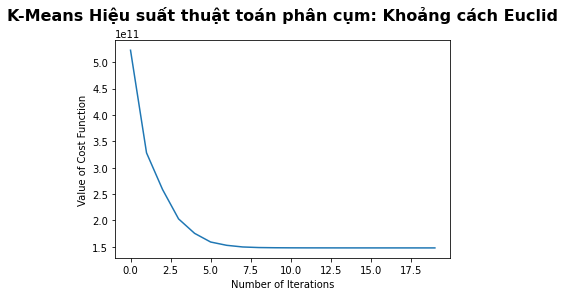

In [44]:
plt.xlabel('Number of Iterations')
plt.ylabel('Value of Cost Function')
plt.title('K-Means Hiệu suất thuật toán phân cụm: Khoảng cách Euclid',pad=20,fontsize=16, fontweight='bold')
plt.plot(range(20),costs_eu)

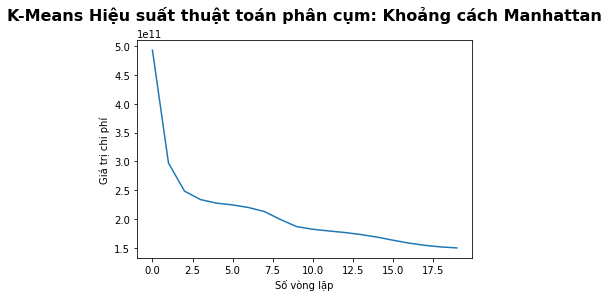

In [45]:
plt.xlabel('Số vòng lặp')
plt.ylabel('Giá trị chi phí')
plt.title('K-Means Hiệu suất thuật toán phân cụm: Khoảng cách Manhattan',pad=20, fontsize=16, fontweight='bold')
plt.plot(range(20),costs_man)

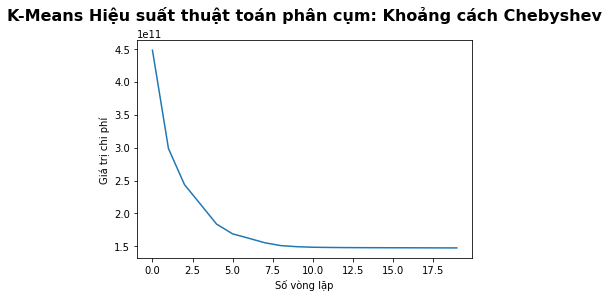

In [46]:
plt.xlabel('Số vòng lặp')
plt.ylabel('Giá trị chi phí')
plt.title('K-Means Hiệu suất thuật toán phân cụm: Khoảng cách Chebyshev',pad=20, fontsize=16, fontweight='bold')
plt.plot(range(20),costs_cheb)

In [47]:
per_chan_e=round(((costs_eu[0]-costs_eu[19])/costs_eu[0])*100,2)
print("Chi phí giảm thiểu khi sử dụng khoảng cách Euclid sau 20 vòng lặp: % " + str(per_chan_e))

Chi phí giảm thiểu khi sử dụng khoảng cách Euclid sau 20 vòng lặp: % 71.74


In [48]:
per_chan_m=round(((costs_man[0]-costs_man[19])/costs_man[0])*100,2)
print("Chi phí giảm thiểu khi sử dụng khoảng cách Mahattan sau 20 vòng lặp: %" + str(per_chan_m))

Chi phí giảm thiểu khi sử dụng khoảng cách Mahattan sau 20 vòng lặp: %69.55


In [49]:
per_chan_m=round(((costs_cheb[0]-costs_cheb[19])/costs_cheb[0])*100,2)
print("Chi phí giảm thiểu khi sử dụng khoảng cách Chebyshev sau 20 vòng lặp: %" + str(per_chan_m))

Chi phí giảm thiểu khi sử dụng khoảng cách Chebyshev sau 20 vòng lặp: %66.99


So Sánh k-mean và K-mean++ (Cả 2 đều sử dụng cách lặp để phân cụm bằng khoảng cách Euclid

In [50]:
# Hàm k-means thường
def kmeanthuong(n_clus,n_iter):
  # khởi tạo các tâm cụm bằng phương pháp naive và xem thời gian khởi tạo
  Gen_Init_Centroids_Naive(n_clus)
  cf=[]
  # khởi tạo và gắn các giá trị global sẽ được broadcast
  global centroid_centres_bd_naive
  global label_with_kmean_naive
  centroid_centres_bd_naive=sc.broadcast(clus_bd_naive.value)
  # Chạy các vòng lặp lại thuật toán
  for i in range(n_iter):  
      # tính khoảng cách và gắn datapoin vào cluster sử dụng Euclid
    assign_cluster=fileRDD.map(lambda x: Euclid_Cluster_Assign_Naive(x,n_clus))   
    # tính và nạp giá trị cost_func
    cost_func=round(assign_cluster.map(lambda x:x[1][2]).sum(),2)
    cf.append(cost_func)
    
    assign_cluster=assign_cluster.map(lambda x:(x[0],x[1][1]))
    # Đưa giá trị label ra ngoài
    label_with_kmean_naive=sc.broadcast(assign_cluster.collect())
    # Tính toán các giá trị tâm các cụm
    new_clusters=assign_cluster.mapValues(lambda v: (v, 1)) \
      .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
      .mapValues(lambda v: v[0]/v[1])
    new_clusters=new_clusters.map(lambda x:x[1]).zipWithIndex().map(lambda x:(x[1],x[0]))
    # giải phóng tài nguyên và thông báo ra ngoài giá trị tâm cụm
    centroid_centres_bd_naive.unpersist()
    centroid_centres_bd_naive=sc.broadcast(new_clusters.collect())  
  return cf

In [51]:
# Hàm k-means++
def kmeanpp(n_clus, n_iter):
  # khởi tạo các tâm cụm bằng phương pháp kmean++
  Gen_Init_Centroids(n_clus)
  cf=[] 
  # khởi tạo và gắn các giá trị global sẽ được broadcast
  global centroid_centres_bd_pp
  global label_with_kmeanpp
  centroid_centres_bd_pp=sc.broadcast(clus_bd.value)
  # Chạy các vòng lặp lại thuật toán
  for i in range(n_iter):  
      # tính khoảng cách và gắn datapoin vào cluster sử dụng Euclid
    assign_cluster=fileRDD.map(lambda x: Euclid_Cluster_Assign(x,n_clus))   
    # tính và nạp giá trị cost_func
    cost_func=round(assign_cluster.map(lambda x:x[1][2]).sum(),2)
    cf.append(cost_func)
    
    assign_cluster=assign_cluster.map(lambda x:(x[0],x[1][1]))
    # Đưa giá trị label ra ngoài
    label_with_kmeanpp=sc.broadcast(assign_cluster.collect())
    # Tính toán các giá trị tâm các cụm
    new_clusters=assign_cluster.mapValues(lambda v: (v, 1)) \
      .reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])) \
      .mapValues(lambda v: v[0]/v[1])
    new_clusters=new_clusters.map(lambda x:x[1]).zipWithIndex().map(lambda x:(x[1],x[0]))
    # giải phóng tài nguyên và thông báo ra ngoài giá trị tâm cụm
    centroid_centres_bd_pp.unpersist()
    centroid_centres_bd_pp=sc.broadcast(new_clusters.collect())  
  return cf

In [52]:
# chạy thuật toán kmeans thường
cost_naive=kmeanthuong(6,20)
kmean_centroids=[x[1] for x in centroid_centres_bd_naive.value]

In [53]:
cost_naive[19]

161923195914.63

In [54]:
# in các nhãn cụm của dữ liệu với phương pháp k-mean thường
with open('labelkmeanthuong.csv', "w") as output:
     output.write('label')
     for x in label_with_kmean_naive.value:
        output.write('\n'+str(x[0]))

In [55]:
#In ra tâm các cụm k-mean thường
kmean_centroids

[array([4.95780591e-01, 5.44303797e-01, 3.78481013e+01, 1.20464135e+00,
        1.22279040e+05, 8.48101266e-01, 7.67932489e-01]),
 array([6.34854772e-01, 6.30705394e-01, 3.42033195e+01, 1.12863071e+00,
        7.26835602e+04, 4.14937759e-03, 2.07468880e-02]),
 array([3.45911950e-01, 5.59748428e-01, 4.54088050e+01, 1.52201258e+00,
        1.82450906e+05, 1.54088050e+00, 1.25786164e+00]),
 array([6.42998028e-01, 6.76528600e-01, 3.23905325e+01, 1.08284024e+00,
        1.01175966e+05, 6.50887574e-01, 5.14792899e-01]),
 array([3.48122867e-01, 4.67576792e-01, 4.17030717e+01, 1.30034130e+00,
        1.47180993e+05, 1.18771331e+00, 1.19112628e+00]),
 array([2.82051282e-01, 3.58974359e-01, 4.89230769e+01, 1.56410256e+00,
        2.55828667e+05, 1.87179487e+00, 1.64102564e+00])]

In [56]:
# chạy thuật toán kmeans++
kmeanpp(6,20)
kmeanpp_centroids=[x[1] for x in centroid_centres_bd_pp.value]

In [57]:
# in các nhãn cụm của dữ liệu với phương pháp k-mean ++
with open('labelkmeanplusplus.csv', "w") as output:
     output.write('label')
     for x in label_with_kmeanpp.value:
        output.write('\n'+str(x[0]))

In [58]:
kmeanpp_centroids

[array([3.04511278e-01, 5.22556391e-01, 4.29586466e+01, 1.37218045e+00,
        1.59058820e+05, 1.33458647e+00, 1.25563910e+00]),
 array([6.22866894e-01, 6.48464164e-01, 3.27969283e+01, 1.08020478e+00,
        1.04961225e+05, 7.16723549e-01, 5.68259386e-01]),
 array([6.16724739e-01, 6.30662021e-01, 3.41289199e+01, 1.12891986e+00,
        7.52331150e+04, 2.43902439e-02, 4.18118467e-02]),
 array([3.45238095e-01, 4.76190476e-01, 4.55357143e+01, 1.47619048e+00,
        2.00943810e+05, 1.69047619e+00, 1.32142857e+00]),
 array([2.8000000e-01, 4.0000000e-01, 5.1040000e+01, 1.7200000e+00,
        2.7413784e+05, 1.8800000e+00, 1.6400000e+00]),
 array([4.79569892e-01, 5.22580645e-01, 3.95913978e+01, 1.26236559e+00,
        1.28478940e+05, 9.20430108e-01, 8.86021505e-01])]

In [59]:
#Thời gian khởi tạo K-mean thường bằng naive với 6 cụm khởi tạo
start_time = time.time()
Gen_Init_Centroids_Naive(6)
end_time = time.time()
t_init = end_time - start_time
print('K-means naive init: {} s'.format(str(round(t_init, 2))))

K-means naive init: 2.25 s


In [60]:
#Thời gian khởi tạo K-mean++  với 6 cụm khởi tạo
start_time = time.time()
Gen_Init_Centroids(6)
end_time = time.time()
t_init = end_time - start_time
print('K-means++ init: {} s'.format(str(round(t_init, 2))))

K-means++ init: 4.98 s
